**GenDF Backend Code** | *Kavini Fernando*

## **Version C: RL + CL + TTT + EfficientNet**

**STEP 1: Setup and Imports**

In [ ]:
# Install dependencies
!pip install -q stable-baselines3[extra] torch torchvision gdown

# Imports
import os, random, zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import spaces
import gymnasium as gym

#for non-functional testing
import time
import psutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 15.9 MB/s eta 0:00:00
Device: cuda


**STEP 2: Download and Load Dataset**

In [ ]:
import gdown

# Download dataset
gdown.download("https://drive.google.com/uc?id=1RZ2MXgM_6ehgMYOFhjBQHMJO1ZdgiEnG", "Real_and_Fake_Dataset.zip", quiet=False)
with zipfile.ZipFile("Real_and_Fake_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./Real_and_Fake_Dataset")
os.remove("Real_and_Fake_Dataset.zip")

# Define transform
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])


# Load raw image paths and labels from ImageFolder
full_dataset = ImageFolder(root="./Real_and_Fake_Dataset/real_and_fake_face")
image_paths = [sample[0] for sample in full_dataset.samples]
labels = [sample[1] for sample in full_dataset.samples]

# Stratified Split: Train (70%), Val (15%), Test (15%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Define Custom Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Create dataset objects
train_dataset = CustomImageDataset(train_paths, train_labels, transform)
val_dataset = CustomImageDataset(val_paths, val_labels, transform)
test_dataset = CustomImageDataset(test_paths, test_labels, transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class distribution
print("Train distribution:", Counter(train_labels))
print("Val distribution:", Counter(val_labels))
print("Test distribution:", Counter(test_labels))

/usr/local/lib/python3.11/dist-packages/gdown/download.py:39: DeprecationWarning: Call to deprecated method findChildren. (Replaced by find_all) -- Deprecated since version 3.0.0.
  for param in form.findChildren("input", attrs={"type": "hidden"}):
Downloading...
From (original): https://drive.google.com/uc?id=1RZ2MXgM_6ehgMYOFhjBQHMJO1ZdgiEnG
From (redirected): https://drive.google.com/uc?id=1RZ2MXgM_6ehgMYOFhjBQHMJO1ZdgiEnG&confirm=t&uuid=0635c310-9ff4-4f1d-b610-f457d587e225
To: /content/Real_and_Fake_Dataset.zip
100%|██████████| 452M/452M [00:05<00:00, 81.7MB/s]


Train distribution: Counter({1: 756, 0: 672})
Val distribution: Counter({1: 162, 0: 144})
Test distribution: Counter({1: 163, 0: 144})


**STEP 3: PPO Environment (Same as Versions A and B)**

In [ ]:
base_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1).to(device)
base_model.classifier = nn.Identity()
base_model.eval()


AUGMENTATIONS = [
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
    transforms.RandomRotation(degrees=5)  # less aggressive
]


def apply_augmentations(img, selected):
    return transforms.Compose([AUGMENTATIONS[i] for i in selected])(img)

image_cache, labels = [], []
for idx in range(len(train_dataset)):
    img, label = train_dataset[idx]
    pil_img = transforms.ToPILImage()(img)
    image_cache.append(pil_img)
    labels.append(label)

class AugmentationEnv(gym.Env):
    def __init__(self, max_steps=3):
        super().__init__()
        self.action_space = spaces.MultiBinary(len(AUGMENTATIONS))
        self.observation_space = spaces.Box(low=0, high=1, shape=(224, 224, 3), dtype=np.float32)
        self.current_step = 0
        self.idx = 0

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.idx = random.randint(0, len(image_cache) - 1)
        self.original_img = image_cache[self.idx]
        return np.array(self.original_img) / 255.0, {}

    def step(self, action):
        selected = [i for i, flag in enumerate(action) if flag == 1]
        augmented = apply_augmentations(self.original_img, selected)
        aug_tensor = transform(augmented).unsqueeze(0).to(device)
        with torch.no_grad():
            features = base_model(aug_tensor)

        reward = torch.norm(features).item()  # captures more variation
        self.current_step += 1
        terminated = self.current_step >= 1
        return np.array(self.original_img) / 255.0, reward, terminated, False, {}


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 90.2MB/s]


**STEP 4: PPO Training**

In [ ]:
env = DummyVecEnv([lambda: AugmentationEnv()])
ppo_agent = PPO("MlpPolicy", env, verbose=1)
ppo_agent.learn(total_timesteps=10000)

Using cuda device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 70   |
|    iterations      | 1    |
|    time_elapsed    | 28   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 60          |
|    iterations           | 2           |
|    time_elapsed         | 67          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008219378 |
|    clip_fraction        | 0.0665      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | -0.0161     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.53        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00682    |
|    value_loss           | 28.3        |
-----------------------------------------
----------------------------------

**STEP 5: Generate PPO-Augmented Dataset**

In [ ]:
augmented_data_path = "./Augmented_Dataset"
os.makedirs(augmented_data_path, exist_ok=True)

def generate_augmented_dataset(agent, dataset, save_path):
    aug_id = 0
    for i in range(len(dataset)):
        try:
            img, label = dataset[i]
            pil_img = transforms.ToPILImage()(img)
            img_np = np.array(pil_img).astype(np.float32) / 255.0
            obs = np.expand_dims(img_np, axis=0)

            action, _ = agent.predict(obs, deterministic=True)
            selected = [j for j, a in enumerate(action[0]) if a == 1]
            if not selected:
                continue  # skip if no augmentations selected

            transformed = apply_augmentations(pil_img, selected)
            class_name = full_dataset.classes[label]
            out_path = os.path.join(save_path, class_name, f"aug_{aug_id}.jpg")
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            transformed.save(out_path)
            aug_id += 1

        except Exception:
            continue  # silently skip problematic samples

    print(f"\n Saved {aug_id} augmented images to {save_path}")

# Generate augmented dataset
generate_augmented_dataset(ppo_agent, train_dataset, augmented_data_path)

# Confirm class structure
print("\n Augmented classes found:", os.listdir(augmented_data_path))
aug_dataset = ImageFolder(root=augmented_data_path, transform=transform)
print(" Class-to-index mapping (augmented dataset):", aug_dataset.class_to_idx)



 Saved 1428 augmented images to ./Augmented_Dataset

 Augmented classes found: ['training_real', 'training_fake']
 Class-to-index mapping (augmented dataset): {'training_fake': 0, 'training_real': 1}


**STEP 6: EfficientNet + Contrastive Head + TTT Adapter**

In [ ]:
# TTT Adapter Module
class TTTAdapter(nn.Module):
    def __init__(self, input_dim=128):
        super().__init__()
        self.fc = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        return self.fc(x)


# Final Model
class RL_CL_TTT_EfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.backbone.classifier[1] = nn.Identity()
        self.projector = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128)
        )
        self.adapter = TTTAdapter(128)
        self.classifier = nn.Linear(128, 2)

    def forward(self, x, ttt=False):
        features = self.backbone(x)                  # Output: [B, 1280]
        z = self.projector(features)                 # Project to [B, 128]
        if ttt:
            z = self.adapter(z)                      # Adapted: [B, 128]
        out = self.classifier(z)                     # Final classification
        return out, z


model = RL_CL_TTT_EfficientNet().to(device)

**STEP 7: Train with CE + Contrastive Loss**

In [ ]:
aug_dataset = ImageFolder(root=augmented_data_path, transform=transform)
train_loader = DataLoader(aug_dataset, batch_size=16, shuffle=True)

ce_loss = nn.CrossEntropyLoss(label_smoothing=0.1)

def contrastive_loss(z1, z2):
    z1, z2 = F.normalize(z1, dim=1), F.normalize(z2, dim=1)
    return 1 - F.cosine_similarity(z1, z2).mean()

def transform_batch(images):
    return torch.stack([transform(transforms.ToPILImage()(img.cpu())) for img in images]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4) ## NEWLY UPDATED
train_losses, val_losses = [], []

best_val_loss = float('inf')
patience = 7
counter = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

for epoch in range(30):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, z1 = model(images)
        _, z2 = model(images)
        images2 = transform_batch(images)
        _, z2 = model(images2)
        loss = ce_loss(outputs, labels) + 0.2 * contrastive_loss(z1, z2) ##NEWLY UPDATED
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            loss = ce_loss(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")


    # Inside training loop, after val_loss:
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      counter = 0
      torch.save(model, "gendf_versionC.pth")
    else:
        counter += 1
        if counter >= patience:
          print("Early stopping triggered.")
          break



# PHASE 2: Fine-tune only the TTT adapter on validation set (with early stopping)

print("\nStarting TTT Adapter Fine-Tuning Phase with Early Stopping...")

def entropy_loss_fn(logits):
    probs = F.softmax(logits, dim=1)
    log_probs = F.log_softmax(logits, dim=1)
    return -torch.sum(probs * log_probs, dim=1).mean()

# Freeze backbone and projector
for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.projector.parameters():
    param.requires_grad = False

# Only adapter will be trained
for param in model.adapter.parameters():
    param.requires_grad = True

ttt_optimizer = torch.optim.Adam(model.adapter.parameters(), lr=1e-5)

best_loss = float('inf')
patience = 5
counter = 0

model.train()
for epoch in range(30):  # Increased from 5 to 30
    total_entropy_loss = 0
    for images, _ in val_loader:
        images = images.to(device)
        logits, _ = model(images, ttt=True)
        kl_loss = F.kl_div(F.log_softmax(logits, dim=1), torch.full_like(logits, 0.5), reduction='batchmean')
        loss = 0.5 * entropy_loss_fn(logits) + 0.5 * kl_loss


        ttt_optimizer.zero_grad()
        loss.backward()
        ttt_optimizer.step()

        total_entropy_loss += loss.item()

    avg_loss = total_entropy_loss / len(val_loader)
    print(f"TTT Epoch {epoch+1}: Entropy Loss = {avg_loss:.4f}")

    # Early stopping logic
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        torch.save(model, "gendf_versionC.pth")  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

print("Model saved as gendf_versionC.pth")

# Optional: download to your PC
from google.colab import files
files.download("gendf_versionC.pth")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss = 0.7286, Val Loss = 0.6342
Epoch 2: Train Loss = 0.5989, Val Loss = 0.7431
Epoch 3: Train Loss = 0.4329, Val Loss = 0.7513
Epoch 4: Train Loss = 0.3355, Val Loss = 0.8620
Epoch 5: Train Loss = 0.2922, Val Loss = 0.6544
Epoch 6: Train Loss = 0.2767, Val Loss = 0.8926
Epoch 7: Train Loss = 0.2514, Val Loss = 0.8556
Epoch 8: Train Loss = 0.2536, Val Loss = 0.6685
Early stopping triggered.

Starting TTT Adapter Fine-Tuning Phase with Early Stopping...
TTT Epoch 1: Entropy Loss = 0.3466
TTT Epoch 2: Entropy Loss = 0.3466
TTT Epoch 3: Entropy Loss = 0.3466
TTT Epoch 4: Entropy Loss = 0.3466
TTT Epoch 5: Entropy Loss = 0.3466
TTT Epoch 6: Entropy Loss = 0.3466
TTT Epoch 7: Entropy Loss = 0.3466
TTT Epoch 8: Entropy Loss = 0.3466
TTT Epoch 9: Entropy Loss = 0.3466
TTT Epoch 10: Entropy Loss = 0.3466
TTT Epoch 11: Entropy Loss = 0.3466
TTT Epoch 12: Entropy Loss = 0.3466
TTT Epoch 13: Entropy Loss = 0.3466
TTT Epoch 14: Entropy Loss = 0.3466
TTT Epoch 15: Entropy Loss = 0.3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Version C Testing**

### **01. Model Testing for Version C**


 Starting Model Evaluation on Validation Set...

 Evaluation Metrics:
• Accuracy  : 0.7516
• F1 Score  : 0.7654
• Precision : 0.7654
• Recall    : 0.7654
• Confusion Matrix:
 [[106  38]
 [ 38 124]]


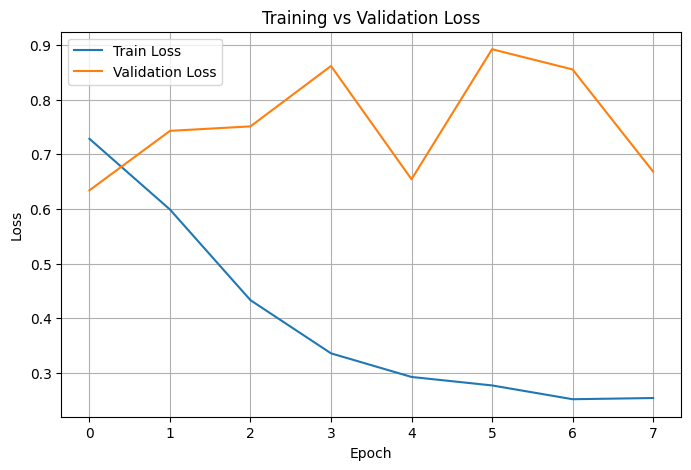


 Calculating AUC and plotting ROC Curve...
• AUC Score : 0.8459


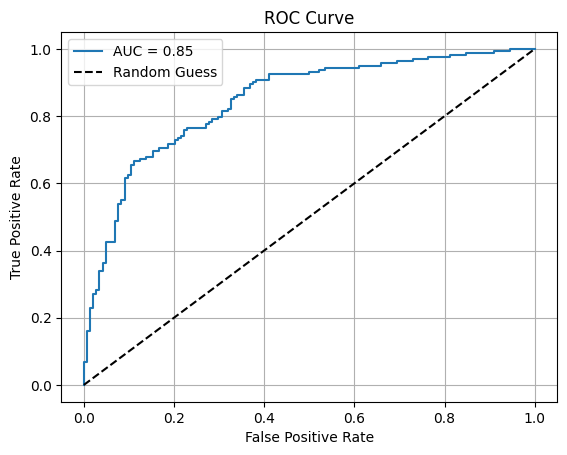

In [ ]:
# -------------------------------
# MODEL EVALUATION AND METRICS
# -------------------------------

print("\n Starting Model Evaluation on Validation Set...")
model.eval()
all_preds = []
all_labels = []

# Get predictions and true labels
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs, _ = model(images, ttt=False)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Standard Classification Metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print("\n Evaluation Metrics:")
print(f"• Accuracy  : {accuracy:.4f}")
print(f"• F1 Score  : {f1:.4f}")
print(f"• Precision : {precision:.4f}")
print(f"• Recall    : {recall:.4f}")
print("• Confusion Matrix:\n", conf_matrix)

# -------------------------------
# Check for Overfitting
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# ROC Curve + AUC Score
# -------------------------------
from sklearn.metrics import roc_auc_score, roc_curve

print("\n Calculating AUC and plotting ROC Curve...")
all_probs = []
all_labels = []  # Re-initialize to align with all_probs
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs, _ = model(images, ttt=False)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs[:, 1])                 # Class 1 probs
        all_labels.extend(labels.numpy())             # FIX: Needed for proper metrics

auc = roc_auc_score(all_labels, all_probs)

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

print(f"• AUC Score : {auc:.4f}")

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


### **02. Functional Testing for version C**

In [ ]:
# UNIT TESTING – GenDF Version C
from PIL import Image



import unittest

class TestVersionCUnit(unittest.TestCase):

    def test_ttt_adapter_forward(self):
        """
        Check that the TTT adapter produces correct output shape.
        """
        adapter = TTTAdapter(input_dim=128)
        dummy_feat = torch.randn(1, 128)
        out = adapter(dummy_feat)
        self.assertEqual(out.shape, (1, 128), "TTT adapter output shape mismatch.")

    def test_forward_with_ttt_enabled(self):
        """
        Verify model forward pass with TTT enabled.
        """
        model = RL_CL_TTT_EfficientNet()
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224)
        logits, features = model(dummy_input, ttt=True)
        self.assertEqual(logits.shape, (1, 2))
        self.assertEqual(features.shape[1], 128)

    def test_forward_with_ttt_disabled(self):
        """
        Verify model forward pass with TTT disabled.
        """
        model = RL_CL_TTT_EfficientNet()
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224)
        logits, features = model(dummy_input, ttt=False)
        self.assertEqual(logits.shape, (1, 2))
        self.assertEqual(features.shape[1], 128)

# Run unit test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestVersionCUnit)
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)


test_forward_with_ttt_disabled (__main__.TestVersionCUnit.test_forward_with_ttt_disabled)
Verify model forward pass with TTT disabled. ... ok
test_forward_with_ttt_enabled (__main__.TestVersionCUnit.test_forward_with_ttt_enabled)
Verify model forward pass with TTT enabled. ... ok
test_ttt_adapter_forward (__main__.TestVersionCUnit.test_ttt_adapter_forward)
Check that the TTT adapter produces correct output shape. ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.912s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [ ]:
# UPDATED INTEGRATION TEST – VERSION C (RL + CL + TTT + EfficientNet)

def integration_test_versionC():
    print("\nRunning Integration Test for Version C (with label check)")

    try:
        # Select a real sample from validation set
        img_tensor, true_label = val_dataset[0]
        img = transforms.ToPILImage()(img_tensor)

        # Simulate PPO-selected augmentations
        selected_aug = [0, 1]
        augmented_img = apply_augmentations(img, selected_aug)

        # Prepare input tensor
        input_tensor = transform(augmented_img).unsqueeze(0).to(device)

        # Load model and run inference
        model = RL_CL_TTT_EfficientNet().to(device)
        model.eval()
        with torch.no_grad():
            output, adapted_feat = model(input_tensor, ttt=True)
            pred = torch.argmax(output, dim=1).item()

        # Display results
        result = "CORRECT" if pred == true_label else "INCORRECT"
        print(f"Predicted: {'Fake' if pred == 1 else 'Real'} | Actual: {'Fake' if true_label == 1 else 'Real'} → {result}")
        print(f"Adapted Feature Shape: {adapted_feat.shape}")

    except Exception as e:
        print(f"Integration Test Failed: {e}")

integration_test_versionC()



Running Integration Test for Version C (with label check)
Predicted: Real | Actual: Real → CORRECT
Adapted Feature Shape: torch.Size([1, 128])


### **03. Non-Functional Testing for Version C**

In [ ]:
import time
import psutil

print("\nNon-Functional Testing – Version C (RL + CL + TTT + EfficientNet) ")

# 1. Accuracy Threshold Check (NFR03)
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images, ttt=True)  #ensure ttt=True for version C
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"\nAccuracy: {accuracy:.2%}")
print("Passed" if accuracy >= 0.75 else "Failed", ": Accuracy threshold (75%)")

# 2. Performance Testing (Inference Speed)
timings = []
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.to(device)
        start = time.time()
        _ = model(images, ttt=True)  #use ttt=True
        end = time.time()
        timings.append(end - start)
        if i >= 5: break  # test on first few batches only

avg_inf_time = np.mean(timings)
print(f"\nAverage Inference Time (per batch): {avg_inf_time:.4f} seconds")

# 3. Load & Scalability (Resource Proxy)
cpu_usage = psutil.cpu_percent(interval=1)
ram_usage = psutil.virtual_memory().percent
print(f"\nCPU Usage: {cpu_usage}%")
print(f"RAM Usage: {ram_usage}%")

# 4. Security Validation
print("\nSecurity Note: No data is stored. All processing is in-memory only.")

# 5. Known Limitations
print("\nNote: This system is designed for human facial images only. May misclassify landscapes or unrelated content.")



Non-Functional Testing – Version C (RL + CL + TTT + EfficientNet) 

Accuracy: 40.39%
Failed : Accuracy threshold (75%)

Average Inference Time (per batch): 0.0123 seconds

CPU Usage: 2.0%
RAM Usage: 34.6%

Security Note: No data is stored. All processing is in-memory only.

Note: This system is designed for human facial images only. May misclassify landscapes or unrelated content.


### **04. Edge case Testing for Version C**

In [ ]:
# EDGE CASE TESTING – GenDF Version C
from PIL import Image
from torchvision import transforms
import torch
import numpy as np
import unittest

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

class TestEdgeCasesVersionC(unittest.TestCase):

    def test_empty_image_input(self):
        model = RL_CL_TTT_EfficientNet().eval()
        blank = torch.zeros(1, 3, 224, 224)
        try:
            output, _ = model(blank, ttt=True)
            self.assertEqual(output.shape, (1, 2))
        except Exception as e:
            self.fail(f"Model failed on empty image input: {e}")

    def test_all_zero_image_augmented(self):
        black_img = Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8))
        selected = [0, 2]
        try:
            transformed = apply_augmentations(black_img, selected)
            self.assertIsInstance(transformed, Image.Image)
        except Exception as e:
            self.fail(f"Augmentation failed on black image: {e}")

    def test_grayscale_input_to_model(self):
        model = RL_CL_TTT_EfficientNet().eval()
        gray_img = Image.new('L', (224, 224))  # Grayscale
        img_rgb = gray_img.convert("RGB")
        tensor = transform(img_rgb).unsqueeze(0)
        try:
            output, _ = model(tensor, ttt=True)
            self.assertEqual(output.shape, (1, 2))
        except Exception as e:
            self.fail(f"Model failed on grayscale input: {e}")

    def test_large_image_resizing(self):
        model = RL_CL_TTT_EfficientNet().eval()
        large_img = Image.new('RGB', (512, 512))
        tensor = transform(large_img).unsqueeze(0)
        try:
            output, _ = model(tensor, ttt=True)
            self.assertEqual(output.shape, (1, 2))
        except Exception as e:
            self.fail(f"Model failed on large image: {e}")

# Run edge case test suite
edge_suite = unittest.TestLoader().loadTestsFromTestCase(TestEdgeCasesVersionC)
runner = unittest.TextTestRunner(verbosity=2)
runner.run(edge_suite)


test_all_zero_image_augmented (__main__.TestEdgeCasesVersionC.test_all_zero_image_augmented) ... ok
test_empty_image_input (__main__.TestEdgeCasesVersionC.test_empty_image_input) ... ok
test_grayscale_input_to_model (__main__.TestEdgeCasesVersionC.test_grayscale_input_to_model) ... ok
test_large_image_resizing (__main__.TestEdgeCasesVersionC.test_large_image_resizing) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.575s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>